In [ ]:
#We update the constraint made about the reionizatoin duration and its redshift

In [439]:
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
import time
import os
from scipy.interpolate import interp1d, interp2d
from scipy import integrate
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
from scipy.stats import multivariate_normal
from scipy import integrate, special

import antisym_func
import error_bar #Tan

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [189]:
def tau(z_ion_1, Delta_z_1, z_ion_He2, Delta_z_He2):
    """
    compute the optical depth of elctron scattering (eqn 85 in Planck 2018:VI)
    TANH model (eqn 1 in Millea & Bouchet 2018)
    assume that the first ionization of Helium is in the same speed of Hydrogen
    x_e : the number density ratio of free electrons and hydrogen nuclei
    -----------
    Parameters:
    -----------
    z_ion_1 : the redshift of the first ionization, presumebly 7
    Delta_z_1 : the duaration of the first ionization, roughly 0.5
    z_ion_He2 : the redshift of the helium second ionization, presumebly 3.5
    Delta_z_He2 : the duaration of the helium second ionization, roughly 0.5
    --------
    Returns:
    --------
    tau : the optical depth of free electrons
    """
    f_He = 0.0811 #the number density ratio of helium to hydrogen nuclei, from 21cmFAST-v1.3
    n_H0 = 1.91795e-07 #cm^(-3), from 21cmFAST-v1.3
    sigma_T = 6.6524e-25 #cm^2, Thomson scattering cross section
    c_speed = 29979245800.0 #cm * s^(-1)
    
    #compute the he fraction of free electrons compared to neutral hydrogens
    Y_z = lambda z: (1 + z)**1.5
    Delta_y = lambda z, Delta_z: 1.5 * (1 + z)**0.5 * Delta_z
    x_e = lambda z, z_ion, Delta_z: \
        0.5 * (1 + np.tanh((Y_z(z_ion) - Y_z(z)) / Delta_y(z_ion, Delta_z)))
    
    #the total free elctrons, contributed both from hydrogen and helium
    x_e_total = lambda z: (1 + f_He) * x_e(z, z_ion_1, Delta_z_1) + f_He * x_e(z, z_ion_He2, Delta_z_He2)
    
    integrand = lambda z: x_e_total(z) * (1 + z)**2 / (antisym_func.H_z(z) / 3.08567758128e19) #H(z) unit from km/s/Mpc to /s
    return n_H0 * sigma_T * c_speed * integrate.quad(integrand, 0, 50, epsrel = 1e-3)[0]


def model_constraint(tau_expected, Delta_z_expected):
    """
    get the middle redshift of reionization and with the tau and Delta_z known
    Based on TANH model (eqn 1 in Millea & Bouchet 2018)
    -----------
    Parameters:
    -----------
    tau_expected : the expected optical depth of free electrons, 0.0519 by Planck 2018
    Delta_z_expected : the expected duration of reionization, around 0.5
    --------
    Returns:
    --------
    tau : the optical depth of free electrons
    """
    def model_computation(z_ion_1, xtol = 0.0001):
        tau_0 = tau(z_ion_1, Delta_z_expected, 3.5, 0.5)
        return [tau_0 -  tau_expected]
    z_ion = fsolve(model_computation, [7])
    return z_ion

the measured redshift by Planck 2018 : 7.34


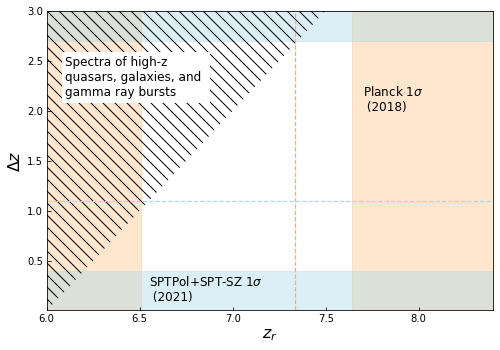

In [311]:
#plot the updated reionization redshift and duration constraint
fig, axs = plt.subplots(1, 1, figsize=(8, 5.5))
axs.set_ylim(0.01,3); axs.set_xlim(6,8.4)

#compute the reionization redshift from the tau (1-sigma) of Planck 2018
z_ion_late, z_ion, z_ion_early =  model_constraint(0.0519 - 0.0079, 0.5)[0], model_constraint(0.0519, 0.5)[0], model_constraint(0.0519 + 0.0030, 0.5)[0]
print('the measured redshift by Planck 2018 : %3.3g'%(z_ion))
x1 = np.linspace(5, z_ion_late, 100)
x2 = np.linspace(z_ion_early, 9, 100) 
y_low, y_upper = [0]*100, [3]*100
axs.fill_between(x1, y_low, y_upper, color = '#fdae61', alpha = 0.3)
axs.fill_between(x2, y_low, y_upper, color = '#fdae61', alpha = 0.3)
axs.text(7.7, 2.0, 'Planck 1$\sigma$ \n (2018)', fontsize = 12)
axs.axvline(x = z_ion, color = '#fdae61', lw = 1.2, ls = '--')
#axs.annotate('Planck (2018)', xy=(z_ion, 2.1), xytext=(7.4, 2.3), arrowprops=dict(facecolor='black', arrowstyle='->'))

#plot the constraint of the reionization duration Delta_z = z(x_H = 0.25) - z(x_H = 0.75)
# Reichardt et al. (2021)
Delta_z_low, Delta_z, Delta_z_upper = 1.1 - 0.7, 1.1, 1.1 + 1.6
x = np.linspace(5, 10, 100)
y_low, y_upper = [Delta_z_low] * 100, [Delta_z_upper] * 100
axs.fill_between(x, [0] * 100, y_low, color = '#abd9e9', alpha = 0.4)
axs.fill_between(x, y_upper, [3] * 100, color = '#abd9e9', alpha = 0.4)
axs.axhline(y = Delta_z, color = '#abd9e9', lw = 1.2, ls = '--')
axs.text(6.55, 0.1, 'SPTPol+SPT-SZ $1\sigma$ \n (2021)', fontsize = 12)
#axs.annotate('SPTPol (2021)', xy=(6.3, Delta_z), xytext=(6., 1.4), arrowprops=dict(facecolor='black', arrowstyle='->'))

# conservative generic upper limit of the form D < 2(z_r - 6) to represent constraints from
# the spectra of high-z quasars, galaxies, and gamma-ray bursts (Bouwens et al. 2015)
x = np.linspace(6, 8, 100)
y = 2 * (x - 6)
y_upper = [3] * 100
axs.fill_between(x, y, y_upper, hatch='\\\\', alpha = 0)
#textbox = matplotlib.patches.FancyBboxPatch((6.2, 2.0), 0.2, 0.2, boxstyle='round,pad=0.1', edgecolor='black', facecolor='white')
#axs.add_patch(textbox)
axs.text(6.1, 2.15, 'Spectra of high-z \nquasars, galaxies, and \ngamma ray bursts', bbox = {"boxstyle" : "square", "color" : "white", }, fontsize = 12)
axs.set_xlabel('$z_r$', fontsize = 16)
axs.set_ylabel('$\Delta z$', fontsize = 16)
plt.savefig('../figures/EoR_redshift_duration_constraint_updated_230410.png', bbox_inches='tight', dpi=200)
plt.show()

In [403]:
# functions used to set reionization parameters with certan optical depth and its duration
def setting_models(zeta, T_vir, R_mfp):
    """
    set the reionization model and gain its history
    -----------
    Parameters:
    -----------
    zeta : the ionizating efficiency
    T_vir : K, the virial temperature
    R_mfp : Mpc, the maximum radius of ionized bubbles
    --------
    Returns:
    --------
    zeta_z_func : the normalized zeta with respect to the redshift
    z_history, HI_history: the neutral fraction with respect to the redshift
    z_dxHdz_history, dxHdz_history : the reionization speed dx_HI/dz with respect to the redshift 
    z_mid : the redshift of 50% neutral fraction z(x_HI = 0.5)
    Delta_z : z(x_HI = 0.75) - z(x_HI = 0.25), the reionization duration 
    """
    #print('model of zeta=%4.4g T_vir=%4.4g computation starts'%(zeta, T_vir,))
    tick = time.time()
    M_max = antisym_func.RtoM(R_mfp)
    mu = 1.22 if T_vir < 9.99999e3 else 0.6
    NUM = 60; z_zeta_interp_array = np.linspace(5, 12, NUM); zeta_z_interp_array = []
    for i in range(NUM):
        zeta_z_interp_array.append(antisym_func.zeta_z(z_zeta_interp_array[i], zeta, T_vir, mu))
    zeta_z_func = interp1d(z_zeta_interp_array, zeta_z_interp_array, kind = 'cubic')
    z_history, HI_history = np.linspace(5, 12, 200), []
    for z in z_history:
        HI_history.append(1 - antisym_func.bar_Q(z, M_max, zeta_z_func, T_vir, mu, antisym_func.PARA_z(z, M_max, zeta_z_func, T_vir, mu)))
    [z_dxHdz_history, dxHdz_history] = antisym_func.dxH_dz_cal(z_history, HI_history)
    #plt.plot(z_history, HI_history)
    
    #compute z_mid and Delta_z
    def redshift_in_grid(z_1, HI_1, z_2, HI_2, HI_expected):
        return (HI_expected - HI_1) / (HI_1 - HI_2) * (z_1 - z_2) + z_1
    for index in range(len(HI_history)):
        if HI_history[index] <= 0.25 and HI_history[index + 1] > 0.25:
            z_25 = redshift_in_grid(z_history[index], HI_history[index], z_history[index+1], HI_history[index+1], 0.25)
        if HI_history[index] <= 0.5 and HI_history[index + 1] > 0.5:  
            z_50 = redshift_in_grid(z_history[index], HI_history[index], z_history[index+1], HI_history[index+1], 0.5)
        if HI_history[index] <= 0.75 and HI_history[index + 1] > 0.75:  
            z_75 = redshift_in_grid(z_history[index], HI_history[index], z_history[index+1], HI_history[index+1], 0.75)
    z_mid = z_50
    Delta_z = z_75 - z_25
    #print('model of zeta=%4.4g T_vir=%4.4g outpot z_mid = %5.5g, Delta_z = %5.5g'%(zeta, T_vir, z_mid, Delta_z))
    return zeta_z_func, z_history, HI_history, z_dxHdz_history, dxHdz_history, z_mid, Delta_z

def model_constraint_history(z_mid_expected, Delta_z_expected, zeta_assumed, T_vir_assumed):
    """
    compute the optical depth of elctron scattering (eqn 85 in Planck 2018:VI)
    -----------
    Parameters:
    -----------
    z_mid_expected : the expected redshift of 50% neutral fraction
    Delta_z_expected : the expected duration of reionization
    zeta_assumed : the starting point of gussing expected zeta
    T_vir_assumed : the starting point of gussing expected virial temperature
    --------
    Returns:
    --------
    zeta, T_vir : parameters of expected EoR history
    """
    def model_computation(parameters):
        zeta = parameters[0]; T_vir = parameters[1]
        zeta_z_func, z_history, HI_history, z_dxHdz_history, dxHdz_history, z_mid, Delta_z \
            = setting_models(zeta, T_vir, 50)
        return [z_mid - z_mid_expected, Delta_z - Delta_z_expected]
    zeta, T_vir = fsolve(model_computation, [zeta_assumed, T_vir_assumed], factor = 0.01, xtol = 0.001)
    return zeta, T_vir

the measured redshift by Planck 2018 : 7.34 (6.51, 7.64)


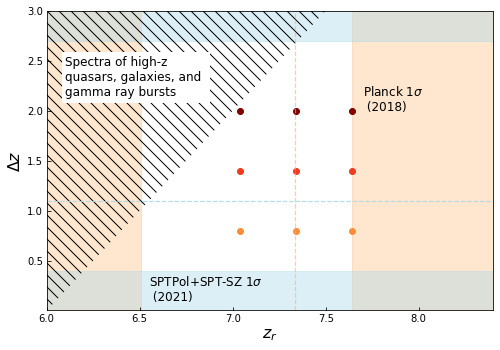

In [371]:
#plot expect z_mid and duration point
fig, axs = plt.subplots(1, 1, figsize=(8, 5.5))
axs.set_ylim(0.01,3); axs.set_xlim(6,8.4)

#compute the reionization redshift from the tau (1-sigma) of Planck 2018
z_ion_late, z_ion, z_ion_early =  model_constraint(0.0519 - 0.0079, 0.5)[0], model_constraint(0.0519, 0.5)[0], model_constraint(0.0519 + 0.0030, 0.5)[0]
print('the measured redshift by Planck 2018 : %3.3g (%3.3g, %3.3g)'%(z_ion, z_ion_late, z_ion_early))
x1 = np.linspace(5, z_ion_late, 100)
x2 = np.linspace(z_ion_early, 9, 100) 
y_low, y_upper = [0]*100, [3]*100
axs.fill_between(x1, y_low, y_upper, color = '#fdae61', alpha = 0.3)
axs.fill_between(x2, y_low, y_upper, color = '#fdae61', alpha = 0.3)
axs.text(7.7, 2.0, 'Planck 1$\sigma$ \n (2018)', fontsize = 12)
axs.axvline(x = z_ion, color = '#fdae61', lw = 1.2, ls = '--', alpha = 0.6)
#axs.annotate('Planck (2018)', xy=(z_ion, 2.1), xytext=(7.4, 2.3), arrowprops=dict(facecolor='black', arrowstyle='->'))

#plot the constraint of the reionization duration Delta_z = z(x_H = 0.25) - z(x_H = 0.75)
# Reichardt et al. (2021)
Delta_z_low, Delta_z, Delta_z_upper = 1.1 - 0.7, 1.1, 1.1 + 1.6
x = np.linspace(5, 10, 100)
y_low, y_upper = [Delta_z_low] * 100, [Delta_z_upper] * 100
axs.fill_between(x, [0] * 100, y_low, color = '#abd9e9', alpha = 0.4)
axs.fill_between(x, y_upper, [3] * 100, color = '#abd9e9', alpha = 0.4)
axs.axhline(y = Delta_z, color = '#abd9e9', lw = 1.2, ls = '--', alpha = 0.9)
axs.text(6.55, 0.1, 'SPTPol+SPT-SZ $1\sigma$ \n (2021)', fontsize = 12)
#axs.annotate('SPTPol (2021)', xy=(6.3, Delta_z), xytext=(6., 1.4), arrowprops=dict(facecolor='black', arrowstyle='->'))

# conservative generic upper limit of the form D < 2(z_r - 6) to represent constraints from
# the spectra of high-z quasars, galaxies, and gamma-ray bursts (Bouwens et al. 2015)
x = np.linspace(6, 8, 100)
y = 2 * (x - 6)
y_upper = [3] * 100
axs.fill_between(x, y, y_upper, hatch='\\\\', alpha = 0)
#textbox = matplotlib.patches.FancyBboxPatch((6.2, 2.0), 0.2, 0.2, boxstyle='round,pad=0.1', edgecolor='black', facecolor='white')
#axs.add_patch(textbox)
axs.text(6.1, 2.15, 'Spectra of high-z \nquasars, galaxies, and \ngamma ray bursts', bbox = {"boxstyle" : "square", "color" : "white", }, fontsize = 12)
axs.set_xlabel('$z_r$', fontsize = 16)
axs.set_ylabel('$\Delta z$', fontsize = 16)

#set points for illustrating 'group'
Delta_z_array = [0.8, 1.4, 2.0]
z_array = [7.04, 7.34, 7.64]

ct = 0
color_list = ['#fd8d3c', '#f03b20', '#800000']
y_index, x_index = [],[]
for Delta_z in Delta_z_array:
    for z in z_array:
        y_index.append(Delta_z)
        x_index.append(z)
    axs.scatter(x_index, y_index, color = color_list[ct], marker = 'o')
    y_index, x_index = [],[]
    ct += 1
plt.savefig('../figures/EoR_redshift_duration_illustration_230411.png', bbox_inches='tight', dpi=200)
plt.show()

In [378]:
#setting model paramters
parameter_dict = {} # (z, Delta_z) : (zeta, T_vir)
zeta, T_vir = 25, 8.9e4 # the first guess parameter for z_r = 7.04, Delta_z = 2.0
DIRECTION = 1 # let the route of the 9 points going along the nearest point
for Delta_z in Delta_z_array[::-1]:
    for z in z_array[::DIRECTION]: 
        tick1 = time.time()
        zeta, T_vir = model_constraint_history(z, Delta_z, zeta, T_vir)
        tick2 = time.time()
        print('model of z_mid = %3.3g, Delta_z = %3.3g cost %3.3g mins \n The parameters are zeta = %3.3g and T_vir = %3.3g'%(z, Delta_z, (tick2 - tick1) / 60, zeta, T_vir))
        parameter_dict[(z, Delta_z)] = (zeta, T_vir)
    DIRECTION *= -1

model of z_mid = 7.04, Delta_z =   2 cost 2.03 mins 
 The parameters are zeta = 20.1 and T_vir = 7.49e+04
model of z_mid = 7.34, Delta_z =   2 cost 1.85 mins 
 The parameters are zeta = 22.3 and T_vir = 6.88e+04
model of z_mid = 7.64, Delta_z =   2 cost 1.79 mins 
 The parameters are zeta = 24.6 and T_vir = 6.34e+04
model of z_mid = 7.64, Delta_z = 1.4 cost 2.94 mins 
 The parameters are zeta = 80.5 and T_vir = 2.15e+05
model of z_mid = 7.34, Delta_z = 1.4 cost 1.87 mins 
 The parameters are zeta = 70.8 and T_vir = 2.32e+05
model of z_mid = 7.04, Delta_z = 1.4 cost 1.82 mins 
 The parameters are zeta = 62.3 and T_vir = 2.52e+05
model of z_mid = 7.04, Delta_z = 0.8 cost 4.68 mins 
 The parameters are zeta = 597 and T_vir = 1.05e+06
model of z_mid = 7.34, Delta_z = 0.8 cost 2.03 mins 
 The parameters are zeta = 701 and T_vir = 9.67e+05
model of z_mid = 7.64, Delta_z = 0.8 cost 2.03 mins 
 The parameters are zeta = 820 and T_vir = 8.88e+05


In [406]:
parameter_dict

{(7.04, 2.0): (20.119378765426656, 74865.70534395464),
 (7.34, 2.0): (22.26128600368908, 68829.02552058127),
 (7.64, 2.0): (24.615695391722333, 63360.572195419176),
 (7.64, 1.4): (80.45182033157266, 214616.74272201114),
 (7.34, 1.4): (70.84133223503822, 232495.93326934928),
 (7.04, 1.4): (62.316328459382305, 252157.32082170525),
 (7.04, 0.8): (597.3657239643137, 1053280.0047920898),
 (7.34, 0.8): (701.0294937826114, 967008.9887855973),
 (7.64, 0.8): (819.8811673660235, 888377.1644579893)}

In [408]:
#compute the history of our groups
z_history_array = []; xH_history_array = []#[group][model]
z_dxHdz_history = []; dxHdz_history = []

for Delta_z in Delta_z_array:
    z_history_array.append([]); xH_history_array.append([])
    z_dxHdz_history.append([]); dxHdz_history.append([])
    for z in z_array:
        zeta, T_vir = parameter_dict[(z, round(Delta_z,2))]
        tick1 = time.time()
        zeta_z_func, z_history, HI_history, z_dxHdz_history_0, dxHdz_history_0, z_mid, Delta_z = \
            setting_models(zeta, T_vir, 50)
        z_history_array[-1].append(z_history);          xH_history_array[-1].append(HI_history)
        z_dxHdz_history[-1].append(z_dxHdz_history_0);    dxHdz_history[-1].append(dxHdz_history_0)
        tick2 = time.time()
        print('model of z = %3.3g, Delta_z = %3.3g cost %3.3g mins'%(z, Delta_z, (tick2 - tick1)/60))

model of z = 7.04, Delta_z = 0.8 cost 0.179 mins
model of z = 7.34, Delta_z = 0.8 cost 0.191 mins
model of z = 7.64, Delta_z = 0.8 cost 0.168 mins
model of z = 7.04, Delta_z = 1.4 cost 0.153 mins
model of z = 7.34, Delta_z = 1.4 cost 0.168 mins
model of z = 7.64, Delta_z = 1.4 cost 0.172 mins
model of z = 7.04, Delta_z =   2 cost 0.165 mins
model of z = 7.34, Delta_z =   2 cost 0.18 mins
model of z = 7.64, Delta_z =   2 cost 0.167 mins


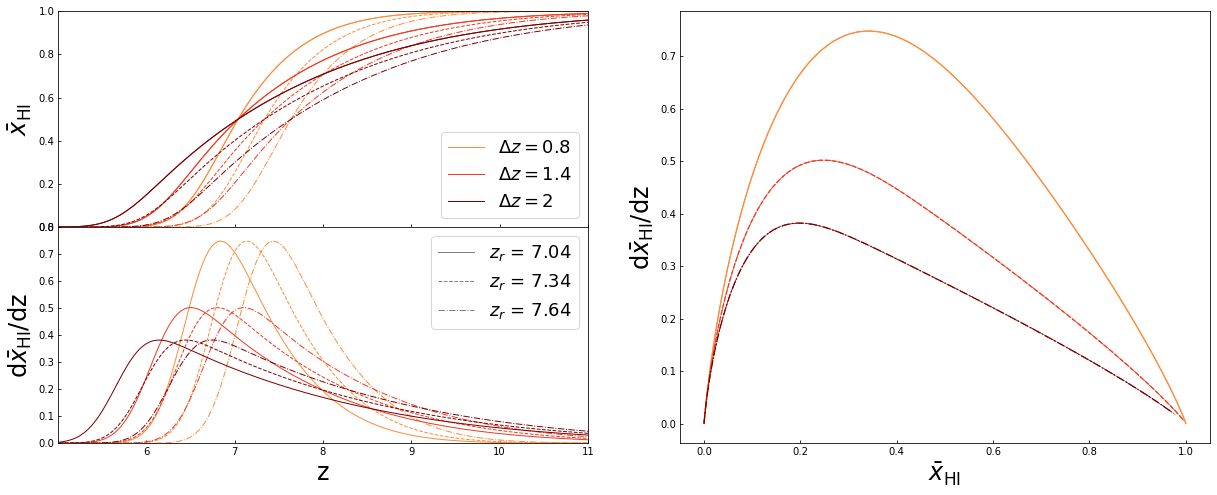

In [405]:
#plot the history of the 3 groups
plt.figure(figsize=(16,6))
FONTSIZE = 24
ax1 = plt.subplot(221, position=[0,1,0.46,0.5])
color_list = ['#fd8d3c', '#f03b20', '#800000']; stylelist = ['-', '--', '-.']
ax1.tick_params(direction='in',length=3)
for i in range(3): # 3 groups
    for j in range(3): # 3 models in each group
        if (j == 0):
            ax1.plot(z_history_array[i][j], xH_history_array[i][j], color = color_list[i], lw=1, ls = stylelist[j], label=r'$\Delta z = %3.3g$'%Delta_z_array[i])
        ax1.plot(z_history_array[i][j], xH_history_array[i][j], color = color_list[i], lw=1, ls = stylelist[j])
ax1.legend(fontsize=18, loc = 4)
ax1.set_ylabel(r'$\bar{x}_{\mathrm{HI}}$',fontsize=FONTSIZE)
ax1.set_ylim(0,1)
ax1.set_xlim(5,9)
ax1.set_xticks([6,7,8,9,10,11])
ax1.set_xticklabels([])

ax2 = plt.subplot(223, position=[0,0.5,0.46,0.5])
for i in range(3): # 3 groups
    for j in range(3): # 3 models in each group
        ax2.plot(z_dxHdz_history[i][j], dxHdz_history[i][j], color = color_list[i], lw=1, ls = stylelist[j])
for j in range(3):
    ax2.plot([1],[1], ls = stylelist[j], color = 'grey', lw = 1, label = '$z_r$ = %3.3g'%z_array[j])
ax2.legend(fontsize=18, loc = 1)
ax2.set_ylim(0.0,0.8); ax2.set_xlim(5,9)
ax2.set_ylabel(r'd$\bar{x}_{\mathrm{HI}}$/dz',fontsize=FONTSIZE)
ax2.set_xlabel('z',fontsize=FONTSIZE)
ax2.tick_params(direction='in',length=3)
ax2.set_xticks([6,7,8,9,10,11])
ax2.set_xticklabels(['6','7','8','9','10','11'])

ax3 = plt.subplot(122, position=[0.54,0.5,0.46,1])
lwlist = [0.3, 0.8, 1.3]
for i in range(3):
    for j in range(3):
        ax3.plot(xH_history_array[i][j][:-1], dxHdz_history[i][j], color = color_list[i], lw=lwlist[j], ls = stylelist[i])
#axs.set_ylim(0.0,0.46); axs.set_xlim(6,11)
ax3.set_ylabel(r'd$\bar{x}_{\mathrm{HI}}$/dz',fontsize=FONTSIZE)
ax3.set_xlabel(r'$\bar{x}_\mathrm{HI}$',fontsize=FONTSIZE)
ax3.tick_params(direction='in',length=3)
#ax3.legend(fontsize=19, loc = 1)
#ax1.set_title('1')

plt.savefig('../figures/history_groups_redshift_duration_230411.png', bbox_inches = 'tight', dpi=400)
plt.show()

[Text(6, 0, '6'),
 Text(7, 0, '7'),
 Text(8, 0, '8'),
 Text(9, 0, '9'),
 Text(10, 0, '10'),
 Text(11, 0, '11')]

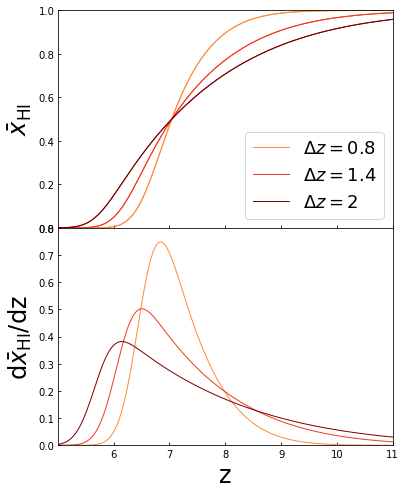

In [424]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
fig.subplots_adjust(wspace=0, hspace = 0)
FONTSIZE = 24
color_list = ['#fd8d3c', '#f03b20', '#800000']; stylelist = ['-', '--', '-.']
axs[0].tick_params(direction='in',length=3)

for i in range(3): # 3 models in each group
    axs[0].plot(z_history_array[i][0], xH_history_array[i][0], color = color_list[i], lw=1, ls = stylelist[0], label=r'$\Delta z = %3.3g$'%Delta_z_array[i])
    axs[0].plot(z_history_array[i][0], xH_history_array[i][0], color = color_list[i], lw=1, ls = stylelist[0])
axs[0].legend(fontsize=18, loc = 4)
axs[0].set_ylabel(r'$\bar{x}_{\mathrm{HI}}$',fontsize=FONTSIZE)
axs[0].set_ylim(0,1)
axs[0].set_xlim(5,9)
axs[0].set_xticks([6,7,8,9,10,11])
axs[0].set_xticklabels([])


for i in range(3): # 3 models in each group
    axs[1].plot(z_dxHdz_history[i][0], dxHdz_history[i][0], color = color_list[i], lw=1, ls = stylelist[0])
#axs[1].legend(fontsize=18, loc = 1)
axs[1].set_ylim(0.0,0.8); axs[1].set_xlim(5,9)
axs[1].set_ylabel(r'd$\bar{x}_{\mathrm{HI}}$/dz',fontsize=FONTSIZE)
axs[1].set_xlabel('z',fontsize=FONTSIZE)
axs[1].tick_params(direction='in',length=3)
axs[1].set_xticks([6,7,8,9,10,11])
axs[1].set_xticklabels(['6','7','8','9','10','11'])

In [482]:
#We compute the characteristic radius of bubbles
def conditional_s_bar(delta_s0, s0, B0, B1):
    conditional_B0 = B0 + B1 * s0 - delta_s0
    s_bar = conditional_B0 / B1 + s0 # chapter 'my guess' in 'Daily_Progress2021'
    return s_bar

def s_bar(s0, B0, B1):
    delta_cross = B0 + B1 * s0
    t_cross = delta_cross / ((2 * s0) ** 0.5)
    Max_fraction = (0.5 - 0.5 * special.erf(t_cross))
    integrand = lambda delta: antisym_func.p_delta_s0(delta, s0) * conditional_s_bar(delta, s0, B0, B1)
    s = integrate.quad(integrand, -6*(s0**0.5), delta_cross, epsrel = 1e-5)[0] + Max_fraction * s0
    return s

#We compute the characteristic radius of bubbles
m_temp_array, S_temp_array = np.logspace(np.log10(antisym_func.RtoM(0.1)), np.log10(antisym_func.RtoM(55)), 1000), []
for m in m_temp_array:
    S_temp_array.append(antisym_func.S(m))
StoM = interp1d(S_temp_array, m_temp_array, kind='cubic')

z_R_array, R_array = np.linspace(5, 11, 100), [[],[],[]]
for i in range(3):
    z_r, Delta_z = 7.04, Delta_z_array[i]
    print('z_r = %3.3g, Delta_z = %3.3g starts'%(z_r, Delta_z))
    tick1 = time.time()
    mu = 1.22 if T_vir < 9.99999e3 else 0.6
    zeta, T_vir = parameter_dict[(z_r, round(Delta_z,2))]
    zeta_z_func, z_history, HI_history, z_dxHdz_history_0, dxHdz_history_0, z_mid, Delta_z = \
            setting_models(zeta, T_vir, 50)
    M_max = antisym_func.RtoM(50)
    s0 = antisym_func.S(M_max)
    for z in z_R_array:
        M_min = zeta_z_func(z) * antisym_func.TtoM(z, T_vir, mu)
        B0 = antisym_func.B_0(z, zeta_z_func, T_vir, mu)
        B1 = antisym_func.B_1(z, zeta_z_func, T_vir, mu)
        PARA = [s0, B0, B1]
        S_bar = s_bar(s0, B0, B1)
        m_bar = StoM(S_bar) #fsolve(lambda m:antisym_func.S(m) - S_bar, [StoM(S_bar)], factor = 0.01, xtol = 0.001)
        R_bar = antisym_func.MtoR(m_bar)
        R_array[i].append(R_bar)
    print('z_r = %3.3g, Delta_z = %3.3g cost %3.3g seconds'%(z_r, Delta_z, time.time() - tick1))
        

z_r = 7.04, Delta_z = 0.8 starts
z_r = 7.04, Delta_z = 0.8 cost 10.4 seconds
z_r = 7.04, Delta_z = 1.4 starts
z_r = 7.04, Delta_z = 1.4 cost 8.8 seconds
z_r = 7.04, Delta_z =   2 starts
z_r = 7.04, Delta_z =   2 cost 9.89 seconds


[Text(6, 0, '6'),
 Text(7, 0, '7'),
 Text(8, 0, '8'),
 Text(9, 0, '9'),
 Text(10, 0, '10'),
 Text(11, 0, '11')]

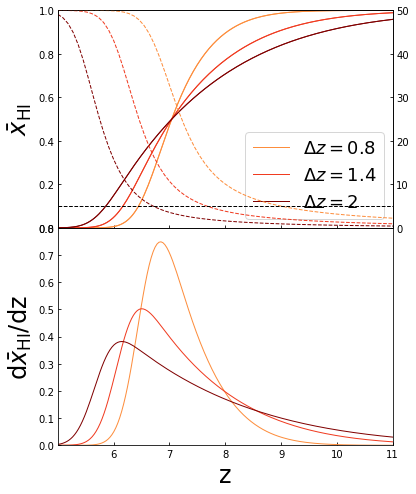

In [491]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
fig.subplots_adjust(wspace=0, hspace = 0)
FONTSIZE = 24
color_list = ['#fd8d3c', '#f03b20', '#800000']; stylelist = ['-', '--', '-.']
axs[0].tick_params(direction='in',length=3)

ax0 = axs[0].twinx()
for i in range(3): # 3 models in each group
    axs[0].plot(z_history_array[i][0], xH_history_array[i][0], color = color_list[i], lw=1, ls = stylelist[0], label=r'$\Delta z = %3.3g$'%Delta_z_array[i])
    axs[0].plot(z_history_array[i][0], xH_history_array[i][0], color = color_list[i], lw=1, ls = stylelist[0])
    ax0.plot(z_R_array, R_array[i], color = color_list[i], lw=1, ls = stylelist[1])
axs[0].legend(fontsize=18, loc = 4)
axs[0].set_ylabel(r'$\bar{x}_{\mathrm{HI}}$',fontsize=FONTSIZE)
axs[0].set_ylim(0,1)
axs[0].set_xlim(5,9)
axs[0].set_xticks([6,7,8,9,10,11])
axs[0].set_xticklabels([])
ax0.set_ylim(0,50)
ax0.axhline(y=5, color = 'black', lw = 1, ls = '--')

for i in range(3): # 3 models in each group
    axs[1].plot(z_dxHdz_history[i][0], dxHdz_history[i][0], color = color_list[i], lw=1, ls = stylelist[0])
#axs[1].legend(fontsize=18, loc = 1)
axs[1].set_ylim(0.0,0.8); axs[1].set_xlim(5,9)
axs[1].set_ylabel(r'd$\bar{x}_{\mathrm{HI}}$/dz',fontsize=FONTSIZE)
axs[1].set_xlabel('z',fontsize=FONTSIZE)
axs[1].tick_params(direction='in',length=3)
axs[1].set_xticks([6,7,8,9,10,11])
axs[1].set_xticklabels(['6','7','8','9','10','11'])

In [490]:
antisym_func.cal_z1_z2(5.5,384,0)

[5.117546136228365, 5.919165374122823]